# Adverserial Examples

Consider an input $x$ with true label $y$, to a machine learning classifier model.  An **adversarial example** for this model would be an input $\tilde{x}$ whose values are only slightly different from $x$ such that the model will misclassify it as a different label $\tilde{y}$.

The initial thought was that these examples had something to do with the nonlinearity inherent in complex machine learning models.   However, the paper ["EXPLAINING AND HARNESSING
ADVERSARIAL EXAMPLES"](https://arxiv.org/pdf/1412.6572.pdf) by Ian J. Goodfellow, Jonathon Shlens and Christian Szegedy of Google, indicate that in fact this behaviour comes about due to the following:
*  the **linear** behaviour of such networks
*  the **high dimensionality** of the input spaces they operate in

They also show that this leads to a relatively easy method for generating such examples.   In this workbook we will follow their prescription.


## Get the data
Here we will use the standard MNIST sample included with Keras.

In [7]:
import keras
import tensorflow
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

short = False
if short:
    train_images = train_images[:7000,:]
    train_labels = train_labels[:7000]
    test_images = test_images[:3000,:]
    test_labels = test_labels[:3000]
#
print("Train info",train_images.shape, train_labels.shape)
print("Test info",test_images.shape, test_labels.shape)
train_images = train_images.reshape((train_images.shape[0],784))
train_images = train_images.astype('float32')/255

test_images = test_images.reshape((test_images.shape[0],784))
test_images = test_images.astype('float32')/255
from keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

print("Test_images shape", test_images.shape)

Train info (60000, 28, 28) (60000,)
Test info (10000, 28, 28) (10000,)
Test_images shape (10000, 784)


## A fully connected network (FCN) MNIST Classifier
The paper states that they can easily generate adverserial examples using a **shallow** MNIST classifier.   In this context, "shallow" typically means 1 hidden layer, and usually just refers to fully connected networks.   "Deep learning" uses multiple hidden layers and pooling techniques, and often refers to models which **learn** their features: convolutional neural networks are thus "deep".

Given that, let's build a very simple single layer FCN.  Below we will also apply this to a "deep" model.

In [8]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(400,activation='relu',input_shape=(28*28,)))
network.add(layers.Dense(10,activation='softmax'))

print("summary",network.summary())

network.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#
history = network.fit(train_images,train_labels_cat,epochs=5,batch_size=128,validation_data=(test_images,test_labels_cat))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                4010      
Total params: 318,010
Trainable params: 318,010
Non-trainable params: 0
_________________________________________________________________
summary None
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 60us/step - loss: 0.2781 - acc: 0.9218 - val_loss: 0.1421 - val_acc: 0.9586
Epoch 2/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.1157 - acc: 0.9659 - val_loss: 0.0997 - val_acc: 0.9686
Epoch 3/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0766 - acc: 0.9776 - val_loss: 0.0792 - val_acc: 0.9760
Epoch 4/5
60000/60000 [==============================] - 3s 5

## Helper display function
We are going to want to display both are starting **true** example, as well as the **adverserial** example we will generate from that true example, so let's define a helper display function.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_img(img):
    img = img.reshape(28,28)
    plt.imshow(img)
    plt.show()


## Quick test of the network
Lets pass in a single example from of test examples.   

True label:                  4
Predicted label:             4
Predicted probability:       0.98978066
Predictions for all classes: [[6.3347463e-05 6.3997794e-07 3.3730743e-05 1.1642200e-07 9.8978066e-01
  5.2809236e-07 7.1310322e-05 2.1597363e-04 9.8960254e-06 9.8238625e-03]]


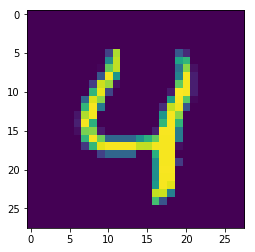

In [11]:
import numpy as np
#
# Define the sample using the index into the numpy arrays
sample = 4
#
# Get the individual prediction for a single sample in the test set
test_image = test_images[sample].reshape(1,784)
test_label = test_labels[sample]
predictions = network.predict(test_image)
#
# Get the max probability
prob = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
predLabel = np.argmax(predictions, axis = 1)
print("True label:                 ",test_label)
print("Predicted label:            ",predLabel[0])
print("Predicted probability:      ",prob[0])
print("Predictions for all classes:",predictions)
#
# Now display
plot_img(test_image)


## Generating Adverserial images
To generate adverserial images, we will start with a test image, and perturb it by a small amount $\eta$.   How do we determine $\eta$?   For our MNIST images, they are encoded using 8-bit precision, with a maximum of 255.   There we expect that changes to an image of the scale less than $\eta$=1/255=0.004 should not be noticeable.  Formally, we will set:
$$\tilde{x} = x + \eta$$
Looking at how this might interact with the weights $w$ in a network, we can see that:
$$w^T\tilde{x} = w^T x + w^T\eta$$
If the average value of the weights is $m$, and the dimension of the weights is $n$, then the impact of such a perturbation is $mn\eta$.  This implies that we can make many small changes to the input $x$, which leave it relatively unchanged, while imparting a large change to the output of the network.   The authors of the above paper call this "accidental steganography": steganography is the practice of concealing a file, message, image, or video within another file, message, image, or video.

The authors suggest this method to determine $\eta$.  Let θ be the parameters of the model, x the input to the model, y the targets associated with x, and J(θ, x, y) be the cost used to train the neural network, then:
$$\eta = \epsilon ~sign (\triangledown_x J(θ, x, y))$$
where the "sign" function simply returns the sign of the argument and $\epsilon$ is a free parameter which controls the size of the step.   The authors suggest numbers like 0.1-0.25, but we will use smaller values like 0.02.

To calculate the gradient of the loss with respect to the input, we will follow exactly the same idea as used in the "Deep Learning" book: section 5.4.2 "Visualizing covnet filters".

Read through the code and comments below to make sure you follow the procedure, at least conceptually.


<class 'numpy.ndarray'>
Predictions [[3.8040540e-08 9.9903381e-01 1.7995112e-06 1.4389487e-06 8.6556181e-05
  2.1652336e-07 1.9202658e-07 8.6158112e-04 1.3456788e-05 8.7864333e-07]]
Test label 4
Pred class [1]
0 [1] [[6.0405392e-07 8.5803533e-01 5.6488843e-06 2.7780634e-05 6.6160853e-04
  3.1404215e-06 8.0052223e-07 1.4100136e-01 2.3582506e-04 2.7837177e-05]]
1 [7] [[3.31651279e-07 3.01940441e-02 1.01954220e-06 3.03618799e-05
  1.05378160e-04 1.85673582e-06 1.17291016e-07 9.69514310e-01
  1.29310036e-04 2.34036706e-05]]
<class 'tensorflow.python.framework.ops.Tensor'>


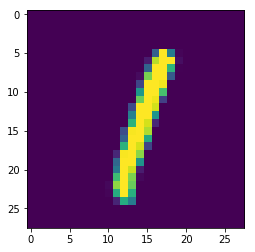

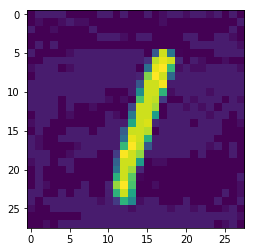

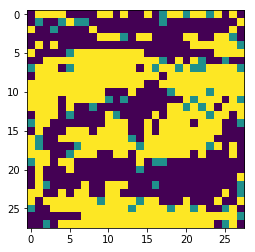

In [14]:
import keras.backend as K
# Initialize adversarial example with input image
sample = 5
test_image = test_images[sample].reshape((1,784))
x = test_image
x_adv = x
print(type(x_adv))
predictions = network.predict(x_adv)
#
# Get the max probabilites for each rows
probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
predclass = np.argmax(predictions, axis = 1)
print("Predictions",predictions)
print("Test label",test_label)
print("Pred class",predclass)
#
# Set variables
epochs = 15
epsilon = 0.02
#
# The target is a one-hot array of 1x10
target = np.zeros((1,10))
#
# Set the target to its true value for the real input
target[0,predclass[0]] = 1
#
# Define the loss function
loss = K.categorical_crossentropy(target, network.output)
#
# Get the gradient of the cost function with respect to the *input*
grads = K.gradients(loss, network.input)[0]
#
# This next line **defines** the "iterate" function using the "K.function" method.
# This takes the given network input and calculates the loss and the gradient.
iterate = K.function([network.input],[loss,grads])
#
# Now actually do the calculations
for i in range(epochs): 
#
# Get the loss and gradient value given our input image
    loss_value, grads_value = iterate([x_adv])
#
# Update the input - make or small changes here!
    x_adv = x_adv + epsilon*K.sign(grads_value)
#
# Now we can get the prediction given our modified image
    preds = network.predict(x_adv,steps=1)
    print(i, np.argmax(preds, axis = 1),preds)
#
# Once our predicted class is no longer the same as our starting class, jump out of the loop
    if predclass != np.argmax(preds, axis = 1)[0]:
        break
#
# Convert from a tensorflow tensor to a numpy array
print(type(x_adv))
x_adv = K.eval(x_adv)
#print(x_adv)
#
# Plot the starting image, the modified image, and their difference
plot_img(x)   
plot_img(x_adv)   
plot_img(x_adv-x)

## Simple Tasks
Here are some things to try:
1.  Try different example inputs - see if the adverserial examples are more difficult to generate for certain digits.
2.  Try playing with different $\epsilon$ values.

## Less Simple Task
Modify the code blocks below to make a simple CNN classifier for MNIST.   Train it and then use the same procedure as above to generate adverserial examples (that code is repeated as well below).

In [6]:
from keras import models
from keras import layers

network = models.Sequential()

#
# Your code here!

network.add(layers.Flatten())
network.add(layers.Dense(10,activation='softmax'))
network.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(network.summary())
#
history = network.fit(train_images,train_labels_cat,epochs=5,batch_size=128,validation_data=(test_images,test_labels_cat))


ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

## Generate adverserial examples for CNN
After fitting your CNN above, you will have to make a trivial change to the code below to get it to work with that network.

In [ ]:
import keras.backend as K
# Initialize adversarial example with input image
sample = 5
test_image = test_images[sample].reshape((1,784))
x = test_image
x_adv = x
predictions = network.predict(x_adv)
#
# Get the max probabilites for each rows
probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
predclass = np.argmax(predictions, axis = 1)
print("Predictions",predictions)
print("Test label",test_label)
print("Pred class",predclass)
#
# Set variables
epochs = 15
epsilon = 0.02
#
# The target is a one-hot array of 1x10
target = np.zeros((1,10))
#
# Set the target to its true value for the real input
target[0,predclass[0]] = 1
#
# Define the loss function
loss = K.categorical_crossentropy(target, network.output)
#
# Get the gradient of the cost function with respect to the *input*
grads = K.gradients(loss, network.input)[0]
#
# This next line **defines** the "iterate" function using the "K.function" method.
# This takes the given network input and calculates the loss and the gradient.
iterate = K.function([network.input],[loss,grads])
#
# Now actually do the calculations
for i in range(epochs): 
#
# Get the loss and gradient value given our input image
    loss_value, grads_value = iterate([x_adv])
#
# Update the input - make or small changes here!
    x_adv = x_adv + epsilon*K.sign(grads_value)
#
# Now we can get the prediction given our modified image
    preds = network.predict(x_adv,steps=1)
    print(i, np.argmax(preds, axis = 1),preds)
#
# Once our predicted class is no longer the same as our starting class, jump out of the loop
    if predclass != np.argmax(preds, axis = 1)[0]:
        break
#
# Convert from a tensorflow tensor to a numpy array
x_adv = K.eval(x_adv)
#print(x_adv)
#
# Plot the starting image, the modified image, and their difference
plot_img(x)   
plot_img(x_adv)   
plot_img(x_adv-x)